## MITx 6.419x - Data Analysis: Statistical Modeling and Computation in Applications

# Module 1 - Review; Statistics, Correlation, Regression, Gradient Descent

In [76]:
# Loading modules

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (8,5)

# Ignoring warnings

import warnings
warnings.filterwarnings('ignore')

# Gamma Ray

The file gamma-ray.csv contains a small quantity of data collected from the Compton Gamma Ray Observatory, a satellite launched by NASA in 1991 (http://cossc.gsfc.nasa.gov/). For each of 100 sequential time intervals of variable lengths (given in seconds), the number of gamma rays originating in a particular area of the sky was recorded. You would like to check the assumption that the emission rate is constant

The Poisson distribution provides a good model as the the gamma rays are discrete and non-negative in nature, and emerge independently of one another at a constant rate in each time interval.

The parameters for the model would then be lambda from the Poisson distribution that denotes the average rate of gamma rays in time interval i and t_i that denotes the length in seconds of this time interval.

$$G_ i \sim Poisson(lambda_i*t_i)$$

The null hypothesis would test whether lambda will remain the same during time (i.e. whether the emission rate is constant) and the alternative whether there is at least one emission rate that is different to one other emission rate.

$$H_0: \lambda _0 = \lambda _1 = \cdots = \lambda _{99}$$
$$H_1: \lambda _ i \neq \lambda _ j$$

In [77]:
# Loading data

gamma_ray = pd.read_csv('data\gamma-ray.csv')
gamma_ray.head()

,seconds,count
0,116.0,0.0
1,112.0,0.0
2,160.0,0.0
3,51.5,0.0
4,102.0,1.0


In [78]:
gamma_ray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   seconds  100 non-null    float64
 1   count    100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


In [79]:
gamma_ray.describe()

,seconds,count
count,100.000000,100.000000
mean,157.182000,0.610000
std,251.579574,1.246368
min,12.500000,0.000000
25%,52.250000,0.000000
50%,100.350000,0.000000
75%,110.250000,1.000000
max,1350.000000,7.000000


In [80]:
# Calculate the maximum likelihood estimator (MLE) for the null model

lambda_hat_H0 = gamma_ray['count'].sum()/gamma_ray['seconds'].sum()
lambda_hat_H0

0.0038808514969907496

The MLE for the null hypothesis is the mean, where as for the alternative hypothesis, it would be each count divided by the seconds in that timeframe

In [81]:
# Calculating the MLE for the alternative model

lambdas_hat_H1 = gamma_ray['count']/gamma_ray['seconds']
lambdas_hat_H1

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.009804
        ...   
95    0.025840
96    0.000000
97    0.000000
98    0.000000
99    0.000000
Length: 100, dtype: float64

A good test statistic would be a quantity that helps to measure how likely the observed data is given to the nullhypothesis, such as the likelihood-ratio test which asymptotic distribution is the Chi-squared distribution.

$$\Lambda (x)= -2 \ln (\frac{\max f(G_0,G_1,\cdots ,G_{99}|\lambda )}{\max f(G_0,G_1,\cdots ,G_{99}|\lambda _0,\cdots , \lambda _{99})})$$

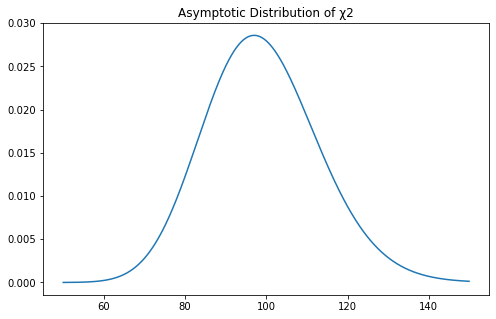

In [82]:
# Plotting the asymptotic distribution Chi-squared for 99 degrees of freedom around the mean

Xs = np.arange(50, 150, 0.1)
ys = scipy.stats.chi2.pdf(Xs, 99)

plt.plot(Xs, ys)
plt.title('Asymptotic Distribution of χ2')
plt.show()

In [83]:
# Calculate the p-value at a significance level of 0.05

p_value = scipy.stats.chi2.isf(0.05, 99)  # the inverse survival function gives the p-value
print('P-value for χ2 with 99 dof at 5%:',p_value)

P-value for χ2 with 99 dof at 5%: 123.22522145336181


The p-value is the rejection region at a significance level of 5 % where when compared with the tests staistic, a larger value from the test statistic would indicate that the null hypothesis should be rejected.

In [84]:
# Calculate test statistic

numerator = scipy.stats.poisson.pmf(gamma_ray['count'], lambda_hat_H0).prod(axis=0)
denominator = scipy.stats.poisson.pmf(gamma_ray['count'], lambdas_hat_H1).prod(axis=0)
test_statistic = -2*np.log(numerator/denominator)
print('Test statistic:', test_statistic)

Test statistic: 104.33272117042188


In [85]:
# Calculate p-value

pvalue = scipy.stats.chi2.sf(test_statistic, 99) # the survival function gives the p-value
print('P-value:', pvalue)

P-value: 0.337398546433923


As the p-value is larger than 0.05 we cannot reject the null hypothesis that the emission rate appears to be constant.

# Molecular Classification of Cancer

The data set golub consists of the expression levels of 3051 genes for 38 tumor mRNA samples. Each tumor mRNA sample comes from one patient (i.e. 38 patients total), and 27 of these tumor samples correspond to acute lymphoblastic leukemia (ALL) and the remaining 11 to acute myeloid leukemia (AML).

You will need to discover how many genes can be used to differentiate the tumor types (i.e. meaning that their expression level differs between the two tumor types.

Source of data: Golub et al., (1999), "Molecular clasification of cancer: class discovery and class prediction by gene expression monitoring", Science, vol. 286: 531-537.

Let $\bar{X}_{\text {ALL},i}$ be the mean of the expression levels for gene i across the ALL mRNA samples. Similarly, let $\bar{X}_{\text {AML},i}$ be the same but for the AML mRNA samples instead.

For ech of these, $N_{\text {ALL}}$ and $N_{\text {AML}}$ are the number of mRNA samples for the ALL tumors and AML tumors respectively.

If $s_{\text {ALL},i}^2$ is the sample variance for gene i across the ALL mRNA observations, then the corresponding variance for $\bar{X}_{\text {ALL},i}$ is

$$\displaystyle  s_{\bar{X}_{\text {ALL}},i}^2 \displaystyle = \frac{s_{\text {ALL},i}^2}{N_{\text {ALL}}}.$$

Similarly, the variance for $\bar{X}_{\text {AML},i}$ is

$$\displaystyle  s_{\bar{X}_{\text {AML}},i}^2\displaystyle = \frac{s_{\text {AML},i}^2}{N_{\text {AML}}}.$$

We can use $\Delta \bar{X}_ i = \bar{X}_{\text {ALL},i} - \bar{X}_{\text {AML},i}$ as a metric for the difference in expression levels for gene i.
The variance of this metric is

$$\displaystyle  s_{\Delta \bar{X}_ i}\displaystyle = s_{\bar{X}_{\text {ALL}},i}^2 + s_{\bar{X}_{\text {AML}},i}^2.$$

This allows us to use the following test statistic:

$$\displaystyle  t_{\text {Welch},i} \displaystyle = \frac{\bar{X}_{\text {ALL},i} - \bar{X}_{\text {AML},i}}{\sqrt{ \frac{s_{\text {ALL},i}^2}{N_{\text {ALL}}} + \frac{s_{\text {AML},i}^2}{N_{\text {AML}}} }}$$

which we can recognize as similar to the t-test statistic, and is itself known as the Welch unequal variances t-test.

The distribution for the Welch test statistic can be approximated by a t-distribution, but with a modified number of degrees of freedomn. The number of degrees of freedom is approximately

$$\displaystyle  \nu _ i \displaystyle \approx \frac{ \left(\frac{s_{\text {ALL},i}^2}{N_{\text {ALL}}} + \frac{s_{\text {AML},i}^2}{N_{\text {AML}}}\right)^2 }{ \frac{1}{\nu _{\text {ALL}}} \left(\frac{s_{\text {ALL},i}^2}{N_{\text {ALL}}}\right)^2 + \frac{1}{\nu _{\text {AML}}} \left( \frac{s_{\text {AML},i}^2}{N_{\text {AML}}} \right)^2 }.$$

where $\nu _{\text {ALL}} = N_{\text {ALL}}-1$ and $\nu _{\text {AML}} = N_{\text {AML}}-1$

Use the Welch t-test to find the number of significantly associated genes ($\alpha \leq 0.05$) using uncorrected p-values.

How many genes are significant?

In [86]:
# Loading data

golub = pd.read_csv('data\golub.csv', index_col=0).T
golub_classnames = pd.read_csv('data\golub_cl.csv')
golub.head()

,1,2,3,4,5,6,7,8,9,10,...,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051
V1,-1.45769,-0.75161,0.45695,3.13533,2.76569,2.64342,3.16885,2.88860,3.22372,3.22372,...,-0.31273,-0.69342,-0.30476,-0.21661,1.08935,0.04695,-0.20467,0.45231,-0.35920,-0.86079
V2,-1.39420,-1.26278,-0.09654,0.21415,-1.27045,1.01416,3.09954,2.95355,3.09954,3.09954,...,-0.45147,-0.80743,-0.72056,-0.65287,0.22701,0.48704,-0.07832,0.42686,-0.43633,-1.39420
V3,-1.42779,-0.09052,0.90325,2.08754,1.60433,1.70477,2.99977,2.99977,2.99977,2.99977,...,-0.76907,-0.51414,-0.11296,0.27332,0.31272,0.72170,-1.00615,0.67579,0.34031,-0.73766
V4,-1.40715,-0.99596,-0.07194,2.23467,1.53182,1.63845,3.28898,3.03972,3.34097,3.35455,...,-0.03863,-1.17554,-0.25346,-0.35475,0.47450,0.58403,-0.88748,0.31524,-0.90930,-1.19031
V5,-1.42668,-1.24245,0.03232,0.93811,1.63728,-0.36075,3.19368,3.21721,3.27515,3.27515,...,-0.99706,-1.42668,-0.99706,-0.89248,0.27257,0.30600,0.07175,-0.57779,-0.36663,-1.42668


In [87]:
golub_classnames.head()

,Unnamed: 0,x
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [88]:
golub_classnames.tail()

,Unnamed: 0,x
33,34,1
34,35,1
35,36,1
36,37,1
37,38,1


In [89]:
golub_classnames[golub_classnames.x ==0]

,Unnamed: 0,x
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [90]:
golub_classnames[golub_classnames.x ==1]

,Unnamed: 0,x
27,28,1
28,29,1
29,30,1
30,31,1
31,32,1
32,33,1
33,34,1
34,35,1
35,36,1
36,37,1


In [91]:
golub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, V1 to V38
Columns: 3051 entries, 1 to 3051
dtypes: float64(3051)
memory usage: 906.1+ KB


In [92]:
golub_classnames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  38 non-null     int64
 1   x           38 non-null     int64
dtypes: int64(2)
memory usage: 736.0 bytes


The first 27 genes correspond to ALL and the remaining 11 to AML

In [93]:
# Extracting the two different tumors from the dataframe

ALL = golub[0:27]
AML = golub[27:]

In [94]:
ALL.shape, AML.shape

((27, 3051), (11, 3051))

In [95]:
# Creating means for the genes

ALL_mean = ALL.mean(axis=0)
AML_mean = AML.mean(axis=0)

In [96]:
ALL_mean.shape, AML_mean.shape

((3051,), (3051,))

In [97]:
# Creating variances for the genes

ALL_var = ALL.var(axis=0, ddof=1)
AML_var = AML.var(axis=0, ddof=1)

In [98]:
ALL_var.shape, AML_var.shape

((3051,), (3051,))

In [99]:
# Creating variables for amount of tumors

ALL_n = ALL.shape[0]
AML_n = AML.shape[0]

In [100]:
ALL_n, AML_n

(27, 11)

In [101]:
# Calculating the Welch's t-test statistic

test_statistic_welch = (ALL_mean - AML_mean)/(np.sqrt((ALL_var/ALL_n)+(AML_var/AML_n)))

In [102]:
# Calculating the number of degrees of freedom

numerator = ( (ALL_var/ALL_n) + (AML_var/AML_n) )**2
denominator = ( ( (ALL_var/ALL_n)**2/(ALL_n-1) )+( (AML_var/AML_n)**2/(AML_n-1) ) ) 
test_dof = numerator/denominator

In [103]:
# 2-sided test for p-values

p_values_welch = scipy.stats.t.sf(np.abs(test_statistic_welch), test_dof)*2

In [104]:
# Counting how many p-values are below the 5% significance threshold

(p_values_welch < 0.05).sum()

1078

In [105]:
# Function from scipy stats for two-sided t-test with two samples

t, p = scipy.stats.ttest_ind_from_stats(ALL_mean, np.sqrt(ALL_var), ALL_n, AML_mean, np.sqrt(AML_var), AML_n, equal_var=False)
print('Number of significantly associated genes:',(p < 0.05).sum())

Number of significantly associated genes: 1078


Now, find the number of significantly associated genes using the Holm-Bonferroni and
Benjamini-Hochberg corrections to the p-values

How many genes are significantly according to the Holm-Bonferroni corrected p-values and according to the Benjamini-Hochberg corrected p-values?

In [106]:
# Holm-Bonferroni

# Sorting p-values in ascending order
p_values_sorted = np.sort(p_values_welch)

# Number of genes in total
genes_n = golub.shape[1] 

# Calculating thresholds with reverse order
holm_bonferroni_thresholds = 0.05/ (np.arange(genes_n)+1)[::-1]

# Comparing p-values with the theshold
holm_bonferroni_significant = p_values_sorted < holm_bonferroni_thresholds

# Finding first p-value that exceeds threshold in the array
holm_bonferroni_not_significant = np.logical_not(holm_bonferroni_significant)

# Taking first True value of the array which is the same as the first False value of the other
holm_bonferroni_first_not_significant = np.argwhere(holm_bonferroni_not_significant)[0]

# Reject all values before the first p-value that exceeds the threshold
# which is equal to the index of the first value that exceeds the threshold

print('Significant genes according to Holm-Bonferroni:',holm_bonferroni_first_not_significant)

Significant genes according to Holm-Bonferroni: [103]


In [107]:
# Benjamini-Hochberg

# Calculating thresholds
benjamini_hochberg_thresholds = 0.05*(np.arange(genes_n)+1)/genes_n

# Comparing p-values with the thresholds
benjamini_hochberg_significant = p_values_sorted < benjamini_hochberg_thresholds

# Finding last p-value that is significant
benjamini_hochberg_last_significant = np.argwhere(p_values_sorted < benjamini_hochberg_thresholds)

# Rejecting the last significant p-value and all values before this
print('Significant genes according to Benjamini-Hochberg:',len(benjamini_hochberg_last_significant))

Significant genes according to Benjamini-Hochberg: 695


Consider the use of the Benjamini-Hochberg correction and Holm-Bonferroni correction on the same data, using the same $\alpha$ to create the corrections.

Will the Benjamini-Hochberg correction always result in as many or more rejections of the null hypothesis when compared to the Holm-Bonfferroni correction?

For the Holm-Bonferroni correction, we have the threshold of $P_ k \leq \frac{\alpha }{m-k+1}$. While for the Benjamini-Hochberg correction, we have the threshold $P_ k \leq \frac{\alpha k}{m}$.

We can verify that 
$$\displaystyle  \frac{\alpha }{m-k+1} \leq \frac{\alpha k}{m}$$

for all values of $k$ in the range $1 \leq k \leq m$.

Thus, the threshold from the Holm-Bonferroni correction is always stricter than for the Benjamini-Hochberg correction. Therefore, the Benjamini-Hochberg correction will reject at least as many null hypotheses, if not more.

# OLS and Gradient Descent

In this problem, we will look at ordinary least squares (OLS) and the gradient descent algorithm.

Read in the synthetic data matrix syn_X.csv and the vector syn_y.csv of "observations". Compute the OLS estimator $\hat{\beta }$ by matrix inversion.

The OLS estimator formula is, in terms of the data matrix ${\boldsymbol X}$ and the observation vector $\mathrm{{\boldsymbol y}}$ is $({\boldsymbol X}^{\intercal }{\boldsymbol X})^{-1} {\boldsymbol X}^{\intercal }\mathrm{{\boldsymbol y}}$

Now apply this formula to the synthetic data matrix and data vector to compute the OLS estimator.

In [108]:
# Loading data

syn_X = np.array(pd.read_csv('data\syn_X.csv'))
y = np.array(pd.read_csv('data\syn_y.csv')).reshape(-1)

In [109]:
# Adding intercept

intercept = np.ones_like(syn_X[:,:1])
X = np.concatenate((intercept, syn_X), axis=1)
X.shape, y.shape

((99, 3), (99,))

In [110]:
# Closed-form solution

def closed_form(X,y):
    beta_hat = np.linalg.inv(X.T@X)@X.T@y
    return beta_hat

beta_hat = closed_form(X,y)
print('OLS:',beta_hat)

OLS: [ 1.92739312  1.26343191 -4.59990074]


Implement gradient descent for the least squares problem in any programming language you wish, and run it on our synthetic data.

Try a number of different choices of step size. You are looking for the optimal step size, which is the choice of step size that results in the fewest number of iterations before convergence. You should use a termination condition that uses a relative precision of $10^{-6}$ or better,
and can use an intial starting $\mathrm{{\boldsymbol \beta }}$ of all zeros (although, in practice, the result depends only very weakly on these choices).

What is the optimal step size that you find?

In [111]:
# Functions for Gradient Descent

def loss_function(beta, X, y):
  return np.sum((y - X @ beta)**2)

def loss_grad(beta, X, y):
  return -2 * (y - X @ beta).T @ X

def gradient_step(beta, step_size, X, y):
  loss, grads = loss_function(beta, X, y), loss_grad(beta, X, y)
  beta = beta - step_size * grads.T # gradient step update
  return loss, beta

def gradient_descent(X, y, step_size, precision, max_iter=10000, warn_max_iter=True):
  beta = np.zeros_like(X[0]) # size of vector for coefficients
  losses = [] # Saving losses after each iteration
  graceful = False
  for _ in range(max_iter):
    beta_last = beta # Save last values of beta for later stopping criterion
    loss, beta = gradient_step(beta, step_size, X, y)
    losses.append(loss)
    # Using the norm of the difference between the new beta and the old beta as a stopping criteria
    if np.sqrt(np.sum((beta - beta_last)/beta)**2) < precision:
      graceful = True
      break
  if not graceful and warn_max_iter:
    print("Reached max iterations.")
  return beta, np.array(losses)

BetaHat = [ 1.92739319  1.26343188 -4.59990068]


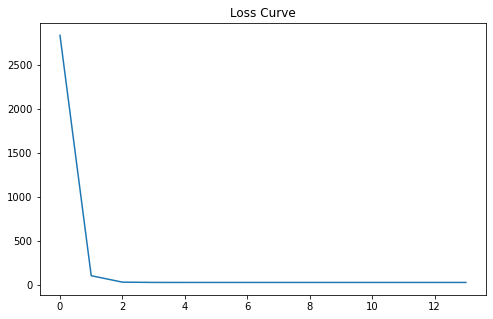

In [112]:
# Running Gradient Descent with learning_rate=0.004, precision=1e-8

beta_gd, losses = gradient_descent(X, y, 0.004, 1e-8)
print("BetaHat = {}".format(beta_gd))

plt.plot(range(len(losses)), losses)
plt.title("Loss Curve")
plt.show()

Optimal step size is 0.004300000000000002 with 9.0 steps


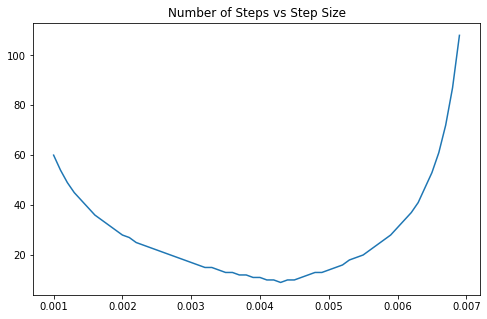

In [113]:
# Scanning over the step size in order to confirm the correct learning rate

step_size_scan_range = np.arange(0.001, 0.007, 0.0001) # trying range from 0.001 to 0.007
step_scan = np.array([ (step_size, len(gradient_descent(syn_X, y, step_size, 1e-6, warn_max_iter=False)[1])) for step_size in step_size_scan_range ]).T
print("Optimal step size is {} with {} steps".format(*step_scan[:, np.argmin(step_scan[1])]))

plt.plot(step_scan[0], step_scan[1])
plt.title("Number of Steps vs Step Size")
plt.show()

We can see from the graph that around 0.004 is the optimal step size (i.e. learning rate) for the algorithm to converge.

Next, we look at some real data. General Motors collected data (found in mortality.csv) from 59 US cities to study the contribution of air pollution to mortality. The dependent variable is the age adjusted mortality (i.e. Mortality). The data includes variables measuring climate characteristics (JanTemp, JulyTemp, RelHum, Rain), variables measuring demographic characteristics of the cities (Educ, Dens, NonWhite, WhiteCollar, Pop, House, Income), and variables recording pollution potential of three different air pollutants (HC, NOx, SO2).

Run your gradient descent algorithm on this data. What do you observe? Try changing different step sizes as before. You will notice that it is difficult to impossible to find convergence. 

We have tried different step sizes, but fail to find a good step size that help the algorithm to converge. Take a look at the data and see if we can find some clues for what is going wrong.

What should be the first step that we try? 

In [114]:
# Loading data

mortality = pd.read_csv('data\mortality.csv')
mortality.head()

,City,Mortality,JanTemp,JulyTemp,RelHum,Rain,Educ,Dens,NonWhite,WhiteCollar,Pop,House,Income,HC,NOx,SO2
0,"Akron, OH",921.87,27,71,59,36,11.4,3243,8.8,42.6,660328,3.34,29560,21,15,59
1,"Albany-Schenectady-Troy, NY",997.87,23,72,57,35,11.0,4281,3.5,50.7,835880,3.14,31458,8,10,39
2,"Allentown, Bethlehem,PA-NJ",962.35,29,74,54,44,9.8,4260,0.8,39.4,635481,3.21,31856,6,6,33
3,"Atlanta, GA",982.29,45,79,56,47,11.1,3125,27.1,50.2,2138231,3.41,32452,18,8,24
4,"Baltimore, MD",1071.29,35,77,55,43,9.6,6441,24.4,43.7,2199531,3.44,32368,43,38,206


In [115]:
# Creating y and X with intercept

y_mortality = np.array(mortality['Mortality'])
X_mortality = np.array(mortality.iloc[:,2:])
intercept = np.ones_like(X_mortality[:,:1])
X_mortality = np.concatenate((intercept, X_mortality), axis=1)
X_mortality.shape, y_mortality.shape

((59, 15), (59,))

Reached max iterations.
BetaHat = [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


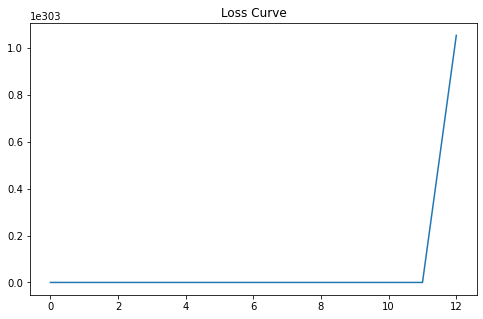

In [116]:
# Running Gradient Descent with learning_rate=0.004, precision=1e-8

beta_gd, losses = gradient_descent(X_mortality, y_mortality, 0.004, 1e-8)
print("BetaHat = {}".format(beta_gd))

plt.plot(range(len(losses)), losses)
plt.title("Loss Curve")
plt.show()

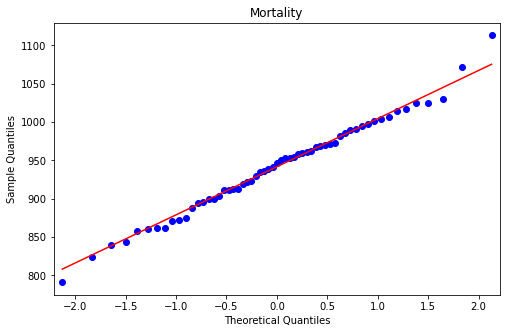

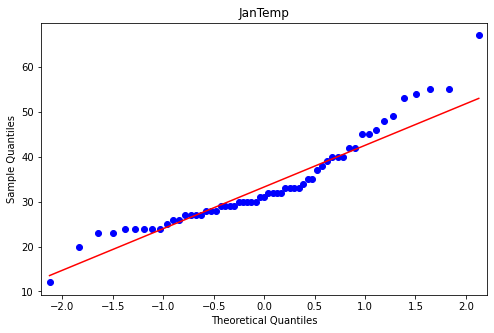

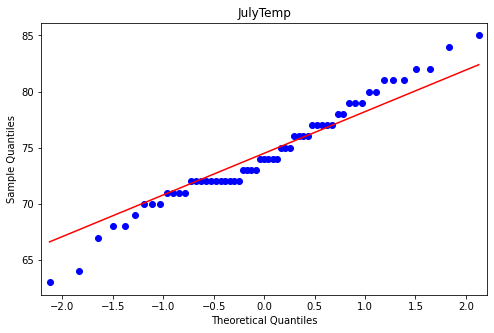

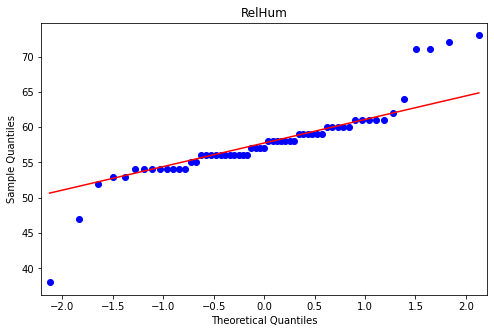

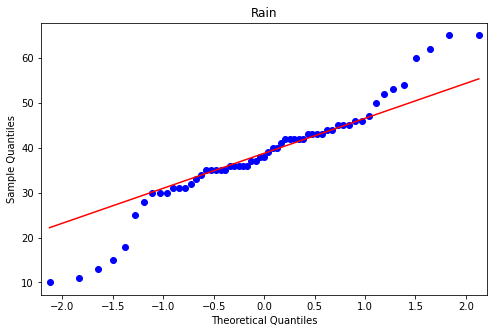

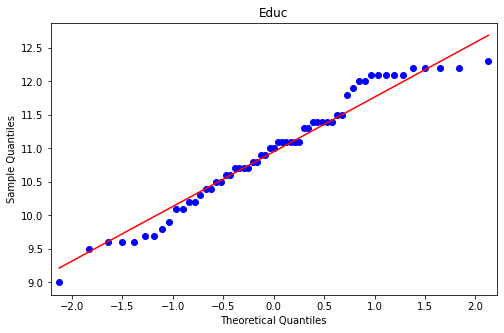

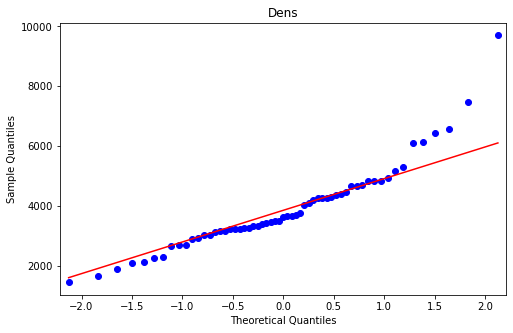

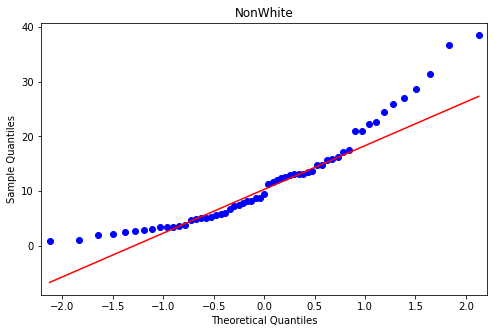

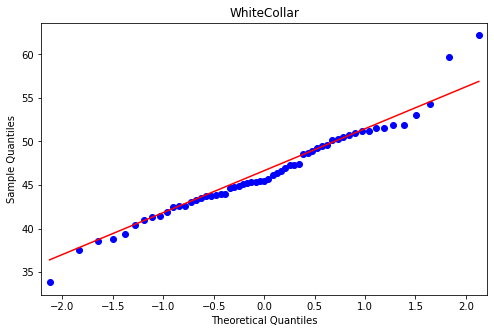

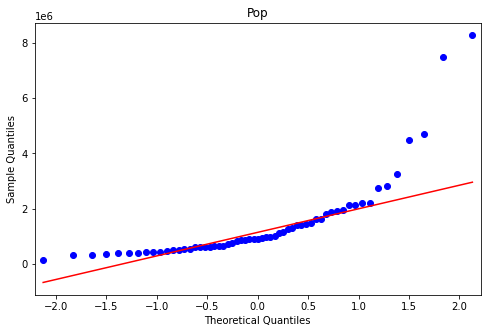

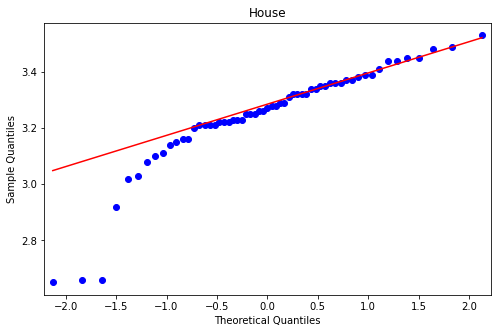

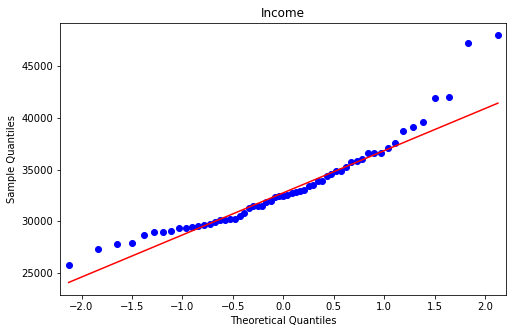

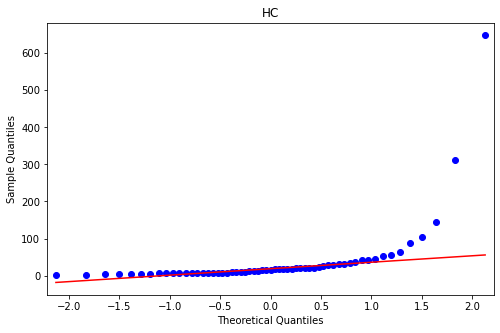

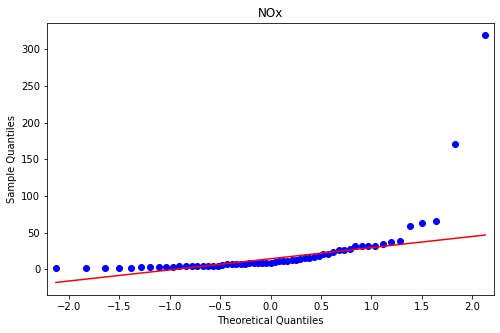

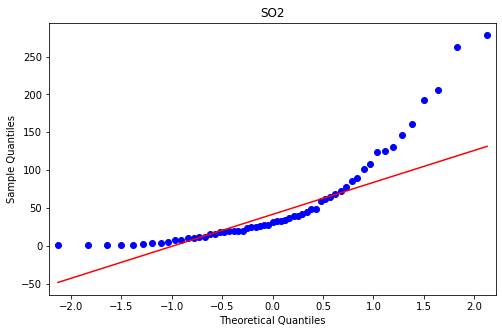

In [117]:
# Plotting QQ-plots of the variables

mortality_int = mortality.iloc[:,1:]

for f in mortality_int.columns:
  fig = sm.qqplot(mortality_int[f], line='q')
  plt.title(f)
  plt.show()

The algorithm doesn't converge because the variables have different scales. The OLS model weights each variable equally and as the range jumps from variables that have values close to zero to variables that have values in the tens of thousands, the optimization produces huge gradients that prevent convergence.

As can be seen from the QQ-plots, some of the variables follow a normal distribution while others have a non-linear relationship.

The first step should be to scale ${\boldsymbol X}$ and $\mathrm{{\boldsymbol y}}$ by the mean and standard deviation of each variable (i.e. normalization of the variables).

Try your adjustment, your adjustment sould allow the optimization to converge.

What solution do you find?

In [118]:
# Scaling features

X_mortality = np.array(mortality.iloc[:,2:]) # taking variables without intercept
X_mortality_scaled = (X_mortality - X_mortality.mean(axis=0)) / X_mortality.std(axis=0, ddof=1)
y_mortality_scaled = (y_mortality - y_mortality.mean()) / y_mortality.std(ddof=1)

In [119]:
# Adding intercept

intercept = np.ones_like(X_mortality[:,:1])
X_mortality_scaled = np.concatenate((intercept, X_mortality_scaled), axis=1)
X_mortality_scaled.shape, y_mortality_scaled.shape

((59, 15), (59,))

BetaHat = [-3.26627614e-16 -2.34389756e-01 -2.17490329e-01  1.17177926e-02
  1.79813299e-01 -1.50526824e-01  1.08942265e-01  7.64360081e-01
 -1.21229320e-01  8.40139087e-02 -1.11460027e-01 -3.04580611e-02
 -9.94879715e-01  8.79717514e-01  8.63037384e-02]
Final loss value = 13.809260380343805


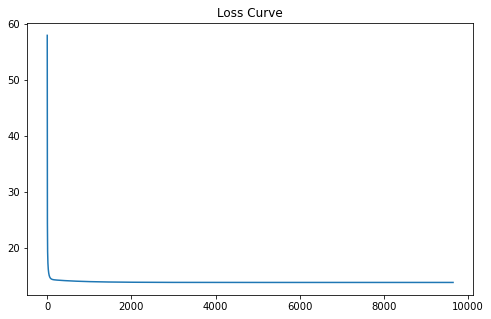

In [120]:
# Gradient Descent with Scaled Features with 0.001 learning rate and 1e-6 precision

m_beta_gd, m_losses = gradient_descent(X_mortality_scaled, y_mortality_scaled, 0.001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))

plt.title("Loss Curve")
plt.plot(range(len(m_losses)), m_losses)
plt.show()

In [121]:
# Closed-form solution for mortality

beta_hat = closed_form(X_mortality_scaled, y_mortality_scaled)
print('OLS:',beta_hat)

OLS: [-2.77555756e-16 -2.34377091e-01 -2.17496828e-01  1.17238925e-02
  1.79754504e-01 -1.50544513e-01  1.08945825e-01  7.64348559e-01
 -1.21202349e-01  8.40325965e-02 -1.11479218e-01 -3.04687337e-02
 -9.96190618e-01  8.81043305e-01  8.61146149e-02]


The results are very similar with both algorithms.

Although we now have a solution, we can do better. Return to looking at your data, which variables could benefit from a logarithmic transformation?

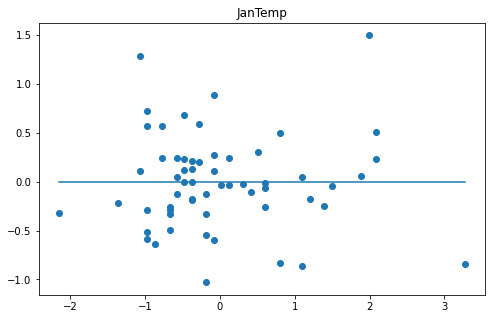

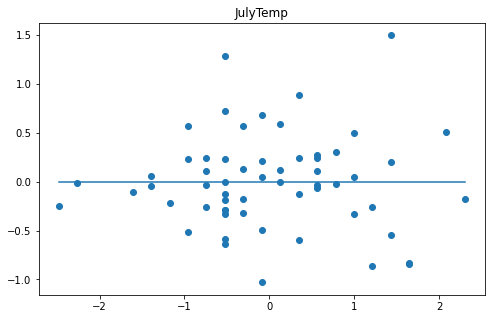

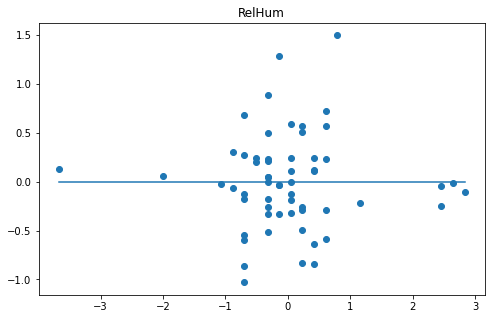

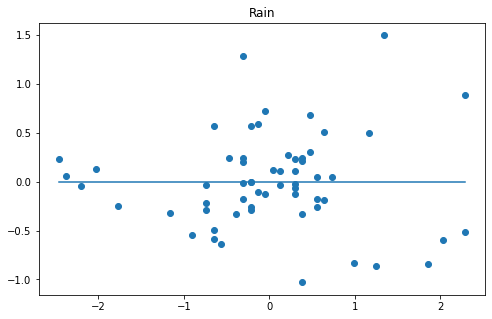

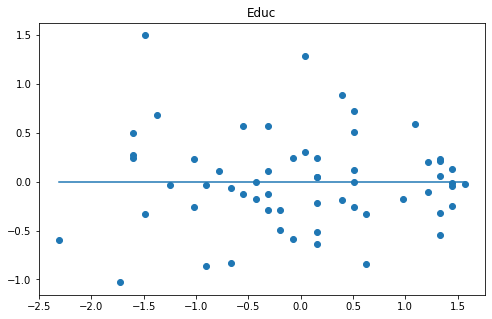

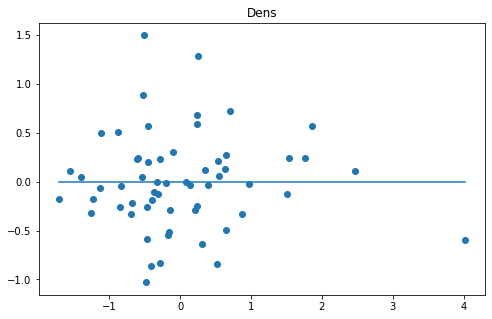

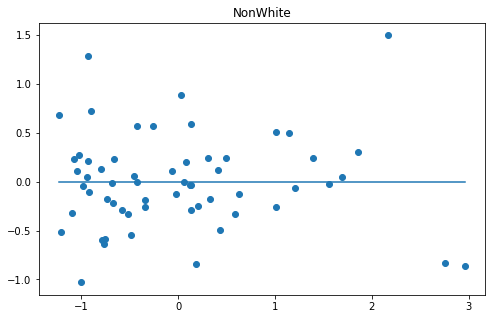

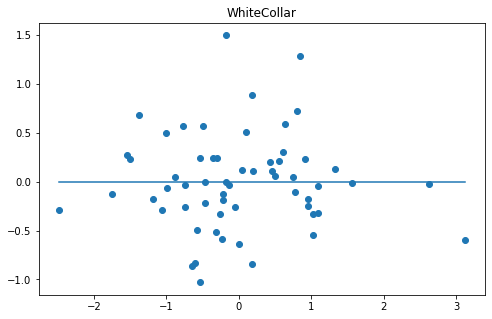

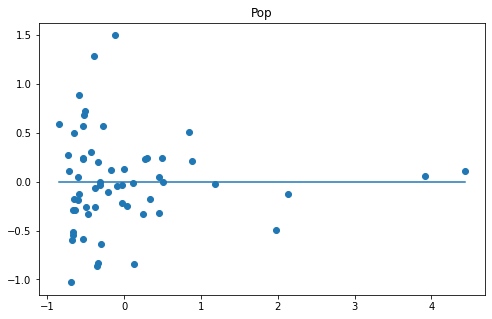

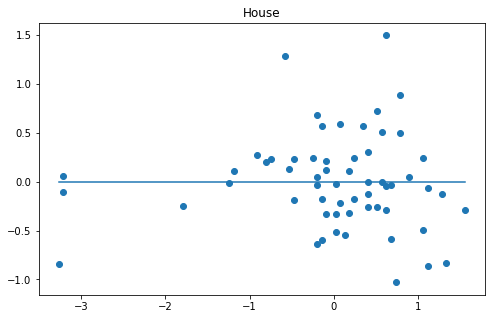

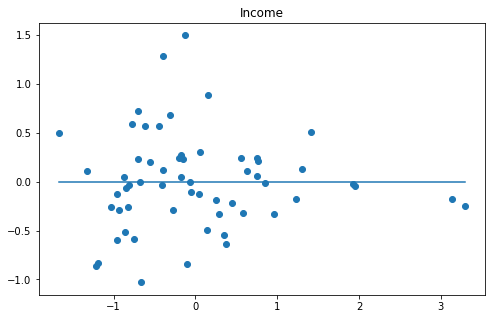

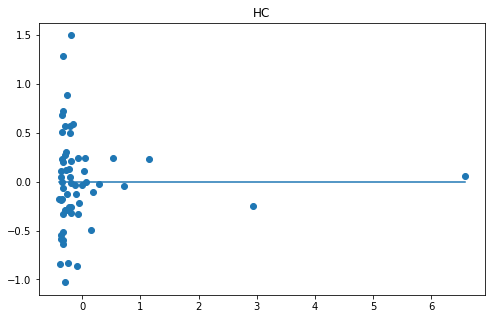

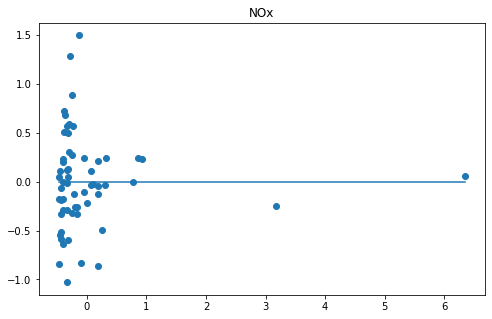

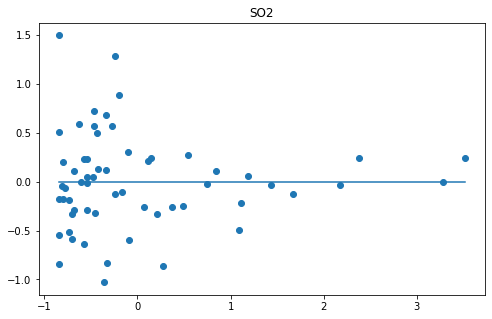

In [122]:
# Plotting first the residuals to assess the quality of the fit

for i, f in enumerate([ f for f in mortality_int.columns if f != 'Mortality']):
  plt.plot(sorted(X_mortality_scaled[:,1:].T[i]), np.zeros_like(y_mortality_scaled))
  plt.scatter(X_mortality_scaled[:,1:].T[i], y_mortality_scaled - X_mortality_scaled.dot(m_beta_gd))
  plt.title(f)
  plt.show()

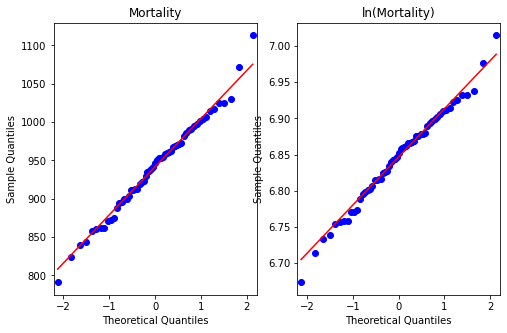

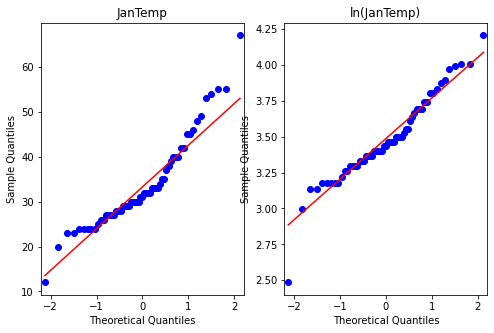

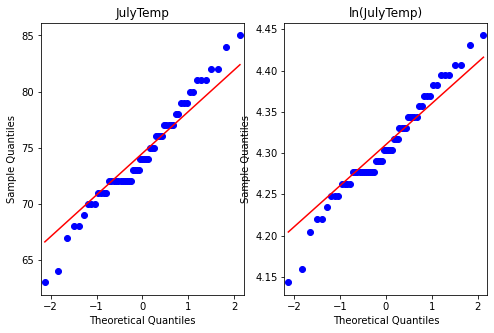

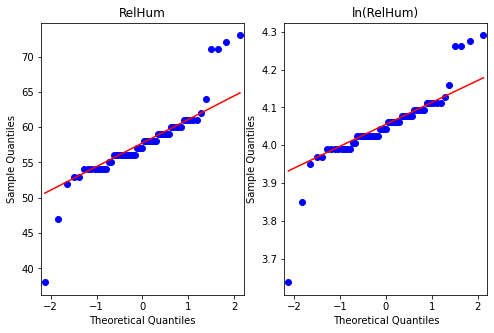

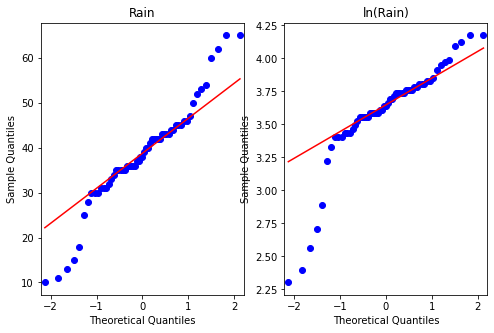

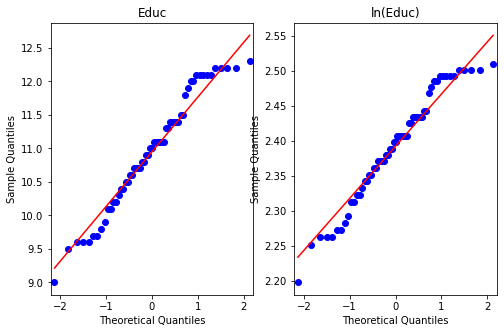

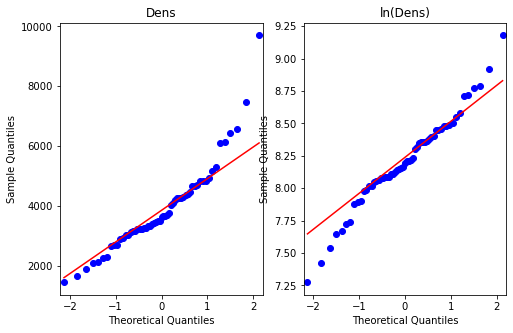

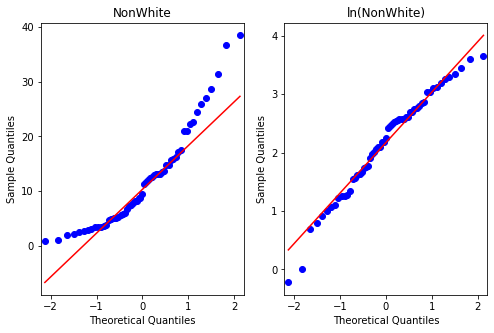

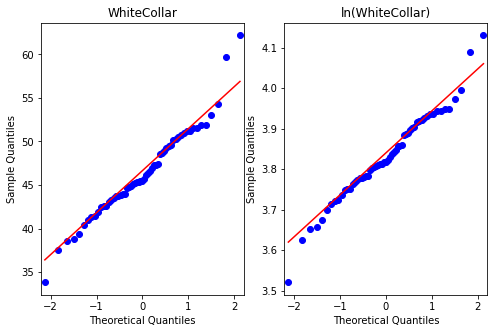

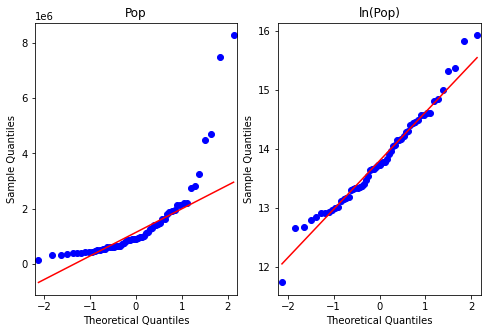

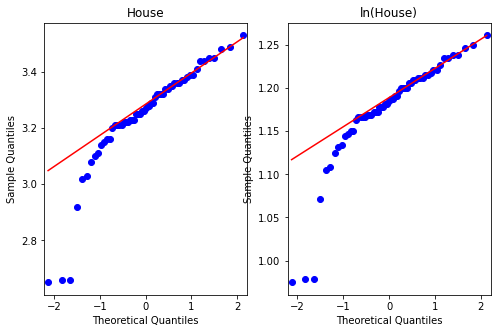

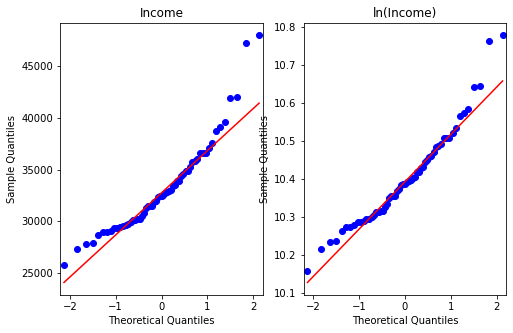

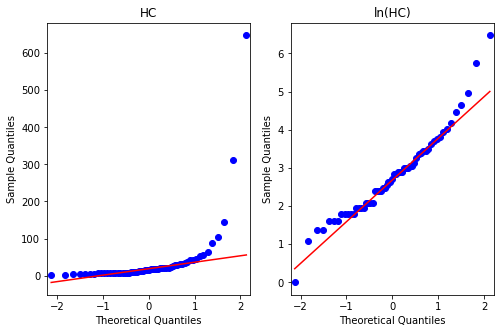

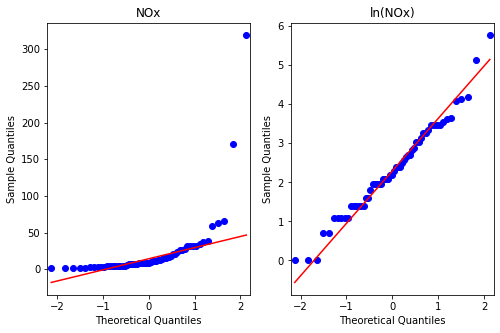

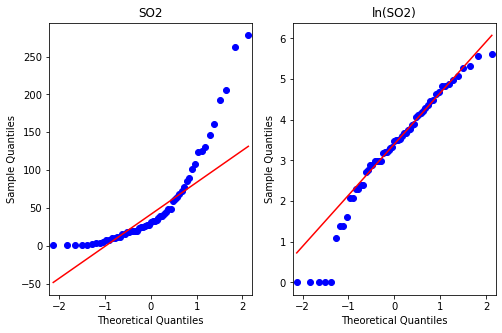

In [123]:
# Plotting QQ-plots of the variables together with their log-transformations

mortality_int = mortality.iloc[:,1:]

for f in mortality_int.columns:
  fig = sm.qqplot(mortality_int[f], line='q', ax=plt.subplot(1, 2, 1))
  plt.title(f)
  fig = sm.qqplot(np.log(mortality_int[f]), line='q', ax=plt.subplot(1, 2, 2))
  plt.title("ln({})".format(f))
  plt.show()

From the residuals we can see that the three last plots of 'HC', 'NOx' and 'SO2' show uneven scattering of points, as well as 'Pop'. These could be log-transformed as can be seen from the QQ-plots. However, if we look at qq-plots, we can also see that 'NonWhite' becomes closer to a normal distribution through a log-transformation as well so this should also be log-transformed.

Try your adjustment, your adjustment should allow the optimization to converge. What solution do you find?

In [124]:
# Transforming features

X_logs = np.log(np.array(mortality[['NonWhite','Pop', 'HC','NOx','SO2']]))
X_features = np.array(mortality[['JanTemp','JulyTemp','RelHum','Rain','Educ','Dens','WhiteCollar','House','Income']])
X_all = np.concatenate((X_features, X_logs), axis=1)

X_scaled = (X_all - X_all.mean(axis=0))/X_all.std(axis=0, ddof=1)
X_scaled = np.concatenate((intercept, X_scaled), axis=1)
y_scaled = y_mortality_scaled

X_scaled.shape, y_scaled.shape

((59, 15), (59,))

In [125]:
# Closed-form solution for mortality with log-transformed and scaled features

beta_hat = closed_form(X_scaled, y_scaled)
print('OLS:',beta_hat)

OLS: [-2.22044605e-16 -3.32706337e-01 -3.98152998e-02  1.11887077e-02
  4.23207083e-01 -1.65682940e-01  1.98540467e-02 -1.32119110e-01
 -4.38582056e-02 -8.07270098e-02  5.41102090e-01  7.54574821e-02
 -2.73906692e-01  6.84274015e-01 -1.04593938e-01]


BetaHat = [-1.88404847e-16 -3.29895463e-01 -2.86317409e-02  1.34512154e-02
  4.23771929e-01 -1.66999234e-01  2.17929254e-02 -1.33989902e-01
 -3.79992610e-02 -7.69510223e-02  5.33677419e-01  7.68465182e-02
 -2.21054774e-01  6.27715513e-01 -9.29821020e-02]
Final loss value = 15.404215617977563


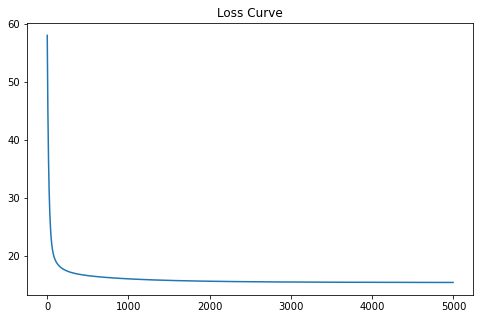

In [126]:
# Running Gradient Descent with 0.0001 learning rate and 1e-6 precision

m_beta_gd, m_losses = gradient_descent(X_scaled, y_scaled, 0.0001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))

plt.title("Loss Curve")
plt.plot(range(len(m_losses)), m_losses)
plt.show()

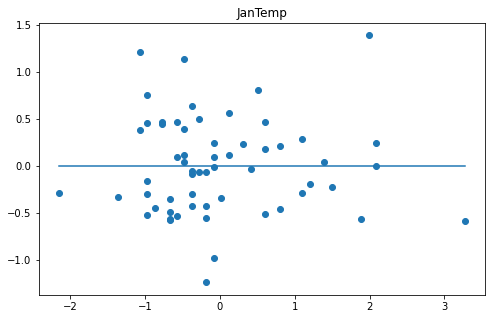

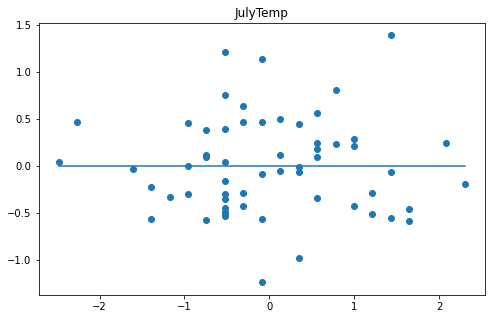

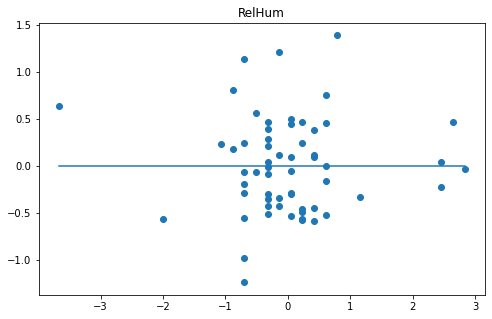

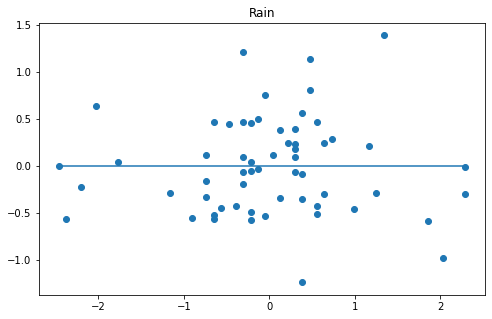

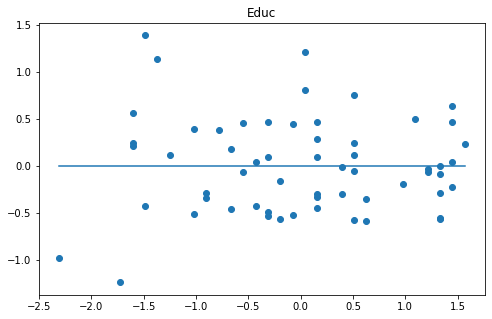

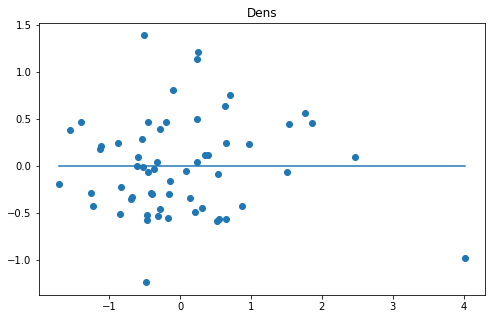

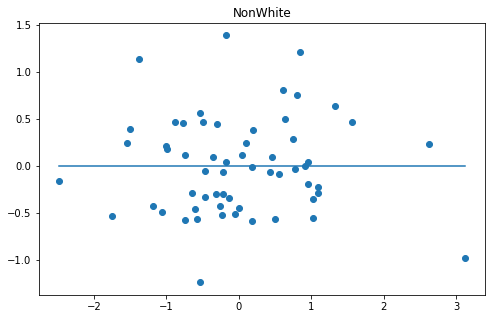

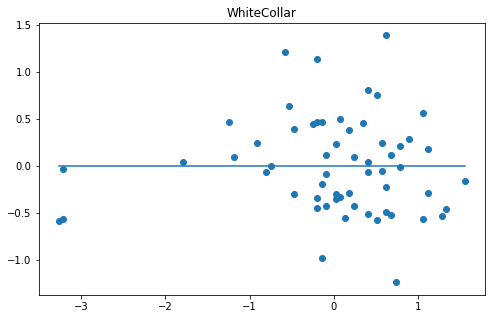

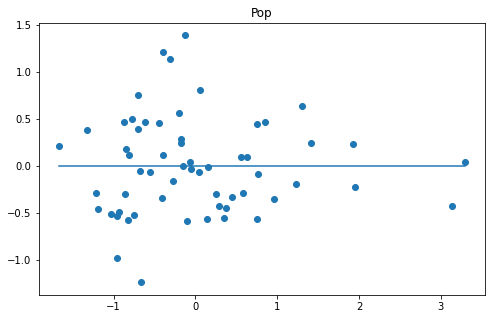

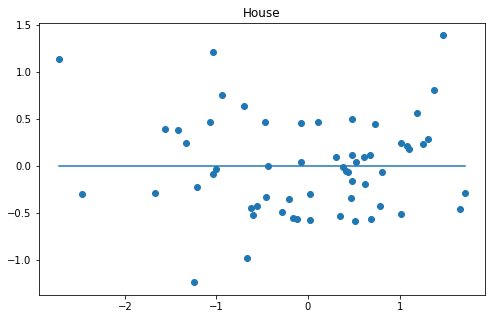

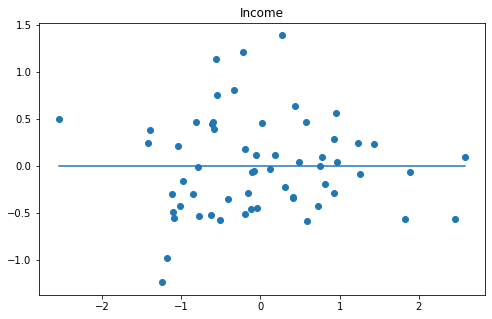

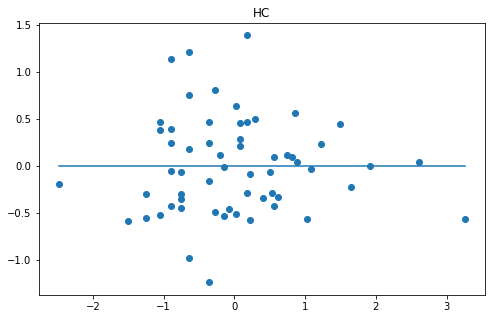

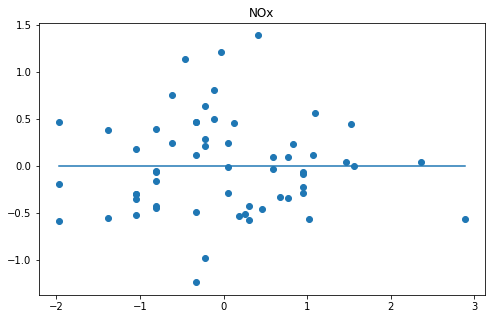

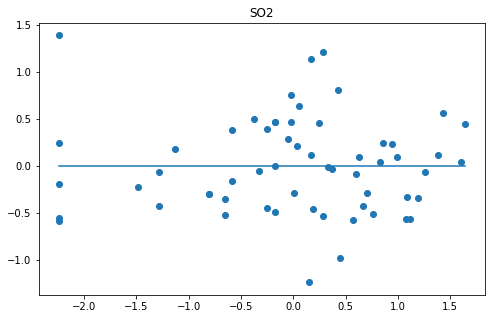

In [127]:
# Plotting residuals

for i, f in enumerate([ f for f in mortality_int.columns if f != 'Mortality']):
  plt.plot(sorted(X_scaled[:,1:].T[i]), np.zeros_like(y_scaled))
  plt.scatter(X_scaled[:,1:].T[i], y_scaled - X_scaled.dot(m_beta_gd))
  plt.title(f)
  plt.show()

The residuals are now better although the overall loss has increased a bit.